In [1]:
#%cd .. 
# Il faut utiliser CD pour s'assurer de rouler dans la racine i.e. '/home/jess/Desktop/ift6759/Solar-Irradiance-Prediction'
%pwd 

'/home/jess/Desktop/IFT-6759/project1/official_repo/Solar-Irradiance-Prediction/models_results/clearsky_cloudinessLabel'

In [2]:
cd ../..

/home/jess/Desktop/IFT-6759/project1/official_repo/Solar-Irradiance-Prediction


In [3]:
import pandas as pd
import numpy as np
import pickle
import math
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
def load_catalog(catalog_path: str) -> pd.DataFrame:
    with open(catalog_path, "rb") as file:
        return pickle.load(file)

In [5]:
Stations = ["BND", "TBL", "DRA", "FPK", "GWN", "PSU", "SXF"]

In [6]:
def get_feature_forStation(catalog, feature, station, start_date, end_date):
    feature = catalog[f'{station}_{feature}']
    if start_date is None:
        return feature.loc[:end_date] 
        
    return feature.loc[start_date:] if end_date is None else feature.loc[start_date:end_date]

def get_feature_forAllStations(catalog, feature, stations, start_date=None, end_date=None, drop_NaN=True):
    all_feature = {}
    for station in stations:
        feature_station = get_feature_forStation(catalog, feature, station, start_date, end_date)
        all_feature[station] = feature_station
    return all_feature

In [7]:
def penalise(index, tmp_clearsky, cloudiness):
    if cloudiness == 'night':
        return tmp_clearsky
    if cloudiness == 'cloudy':
        return tmp_clearsky - (tmp_clearsky*0.5)
    if cloudiness == 'slightly cloudy':
        return tmp_clearsky - (tmp_clearsky*0.25)
    if cloudiness == 'clear':
        return tmp_clearsky
    if cloudiness == 'variable':
        return tmp_clearsky - (tmp_clearsky*0.05)
    else:
        print('ELSE!!')
        print(cloudiness)
        return tmp_clearsky

In [26]:
def get_RMSE_forStations(true_ghi, clearsky_ghi):
    return np.sqrt(np.mean((true_ghi-clearsky_ghi)**2))

def get_RMSE_forAllStations(stations, true_ghi, clearsky_ghi):
    rmse = {}
    for station in stations:
        clearsky_ghi = []
        true_ghi = []
        for index, row in true_ghi_2015[station].iteritems():
            tmp_clearsky  = clearsky_ghi_2015[station].loc[index]
            tmp_true = true_ghi_2015[station].loc[index]
            if not(math.isnan(tmp_clearsky) or math.isnan(tmp_true)):
                clearsky_ghi.append(clearsky_ghi_2015[station].loc[index])
                true_ghi.append(true_ghi_2015[station].loc[index])
        rmse[station] = get_RMSE_forStations(np.array(clearsky_ghi), np.array(true_ghi))
    return rmse

def get_RMSE_forAllStations_perMonths(stations, true_ghi, clearsky_ghi, cloudiness, penalize):
    rmse = {}
    for station in stations:
        i = 1
        rmse[station] = []
        clearsky_ghi = []
        true_ghi = []
        for index, row in true_ghi_2015[station].iteritems():
            tmp_clearsky  = clearsky_ghi_2015[station].loc[index]
            tmp_true = true_ghi_2015[station].loc[index]
            
            if not(math.isnan(tmp_clearsky) or math.isnan(tmp_true)):
                if penalize:
                    tmp_clearsky = penalise(index, tmp_clearsky, cloudiness[station].loc[index])
                clearsky_ghi.append(tmp_clearsky)
                true_ghi.append(tmp_true)
                
            if index.month > i:
                rmse[station].append(get_RMSE_forStations(np.array(clearsky_ghi), np.array(true_ghi)))
                clearsky_ghi = []
                true_ghi = []
                i+=1
        rmse[station].append(get_RMSE_forStations(np.array(clearsky_ghi), np.array(true_ghi)))             
    return rmse

In [17]:
def result(result):
    for station in Stations:
        print(station, ":", np.mean(result[station]))

In [23]:
cd models_results/clearsky_cloudinessLabel

/home/jess/Desktop/IFT-6759/project1/official_repo/Solar-Irradiance-Prediction/models_results/clearsky_cloudinessLabel


In [38]:
def gen_graph(result):
    Months = ['', 'Jan', 'Mar',  'May', 'Jul', 'Sep',  'Nov', 'Dec']
    for i, station in enumerate(Stations):
        plt.figure(i)
        plt.title(f"RMSE at station {station} in 2015")
        plt.xlabel('Months')
        plt.ylabel('RMSE')
        plt.grid(True)
        plt.gca().set_xticklabels(Months)
        plt.plot(result[station])
        plt.savefig(f'RMSE_{station}.png')
        
def gen_compare_graph(result, result_cloudy):
    Months = ['', 'Jan', 'Mar',  'May', 'Jul', 'Sep',  'Nov', 'Dec']
    for i, station in enumerate(Stations):
        plt.figure(i)
        plt.title(f"RMSE at station {station} in 2015")
        plt.xlabel('Months')
        plt.ylabel('RMSE')
        plt.grid(True)
        plt.gca().set_xticklabels(Months)
        plt.plot(result[station], label='Clearsky RMSE')
        plt.plot(result_cloudy[station], label='Clearsky with cloudiness RMSE')
        plt.legend(loc="upper right")
        plt.savefig(f'RMSE_COMPARE_{station}.png')

In [19]:
catalog = load_catalog("../project1_data/catalog.helios.public.20100101-20160101.pkl")

In [20]:
clearsky_ghi_2015 = get_feature_forAllStations(catalog, 'CLEARSKY_GHI', Stations, start_date='2015-01-01')
true_ghi_2015 = get_feature_forAllStations(catalog, 'GHI', Stations, start_date='2015-01-01')
cloudiness_2015 = get_feature_forAllStations(catalog, 'CLOUDINESS', Stations, start_date='2015-01-01')

In [27]:
rmse_2015_months_cloudiness = get_RMSE_forAllStations_perMonths(Stations, true_ghi_2015, clearsky_ghi_2015, cloudiness_2015, True)
rmse_2015_months = get_RMSE_forAllStations_perMonths(Stations, true_ghi_2015, clearsky_ghi_2015, cloudiness_2015, False)

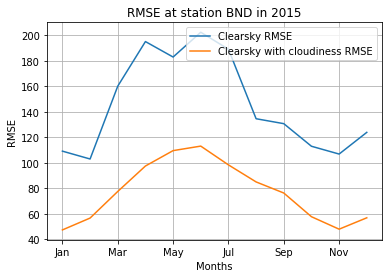

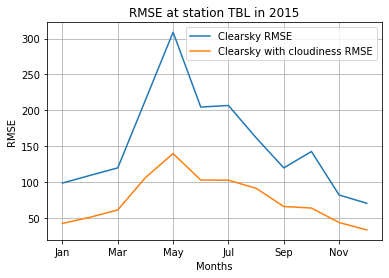

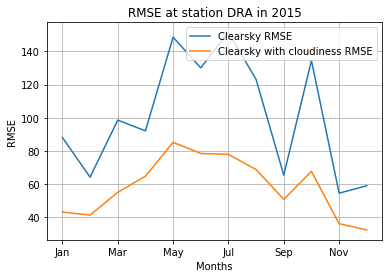

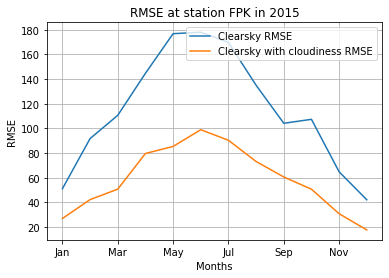

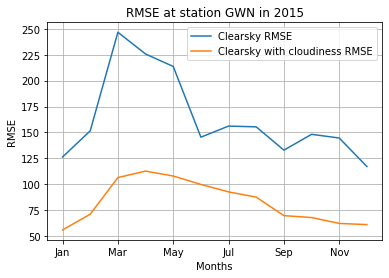

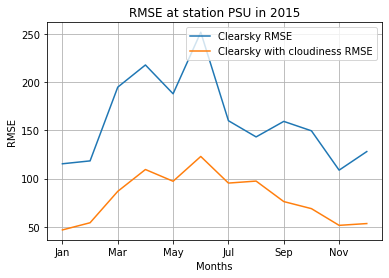

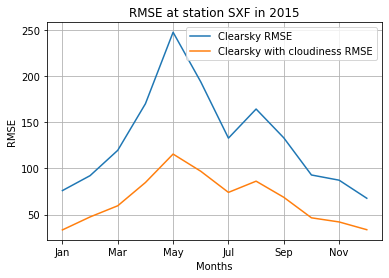

In [39]:
gen_compare_graph(rmse_2015_months, rmse_2015_months_cloudiness)

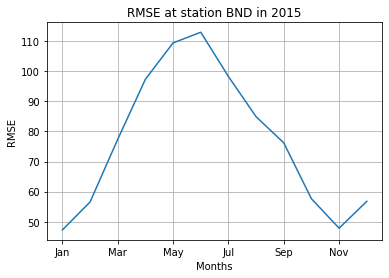

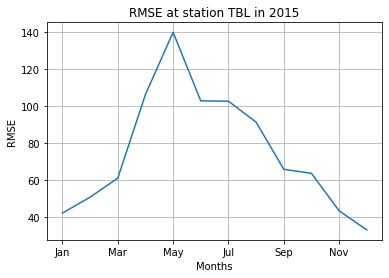

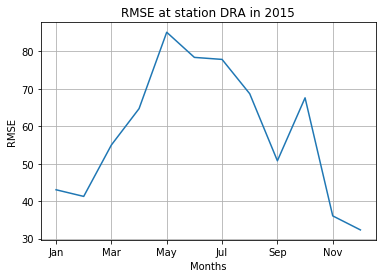

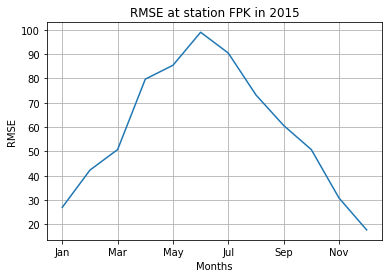

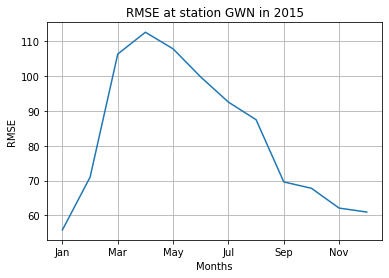

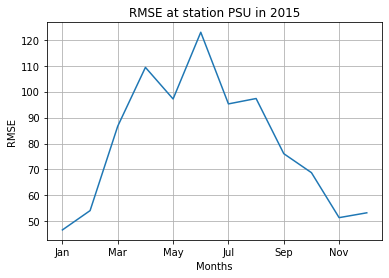

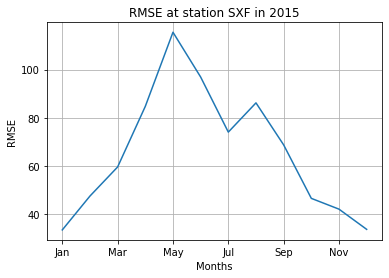

In [40]:
gen_graph(rmse_2015_months_cloudiness)

In [44]:
result(rmse_2015_months_cloudiness)

BND : 76.88728913124487
TBL : 75.244799790754
DRA : 58.41060655171887
FPK : 58.984991411871285
GWN : 82.8274769773622
PSU : 79.92377972693009
SXF : 65.68077120113342
